# Analysis of the attack on Adult without clustering before the construction of the blackbox

For this attack I used adaboost instead of the random forests both for the shadow models and the attack models.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pathlib import Path
import os
import sys
import bz2
import pickle
np.random.seed(10)
# adds the visibility of the mlem module, needed to load the attack models
sys.path.append("../../../../..") 
import mlem
from mlem.ensemble import HardVotingClassifier
from mlem.utilities import report_and_confusion, load_pickle_bz2

In [26]:
import warnings

In [27]:
BLACK_BOX_PATH = '../BB_DATA/adult_rf_noclustering.bz2'

In [28]:
def get_attack_mod(index:int, targets=[0,1], base_folder=None):
    """
    Args:
        index - row of the dataset on which the attack model was built
        targets (int | List(int)) - targets for the attack model.
    Returns:
        List containing the attack models (or model) for that particular index
    """
    if type(targets) is int:
        targets = [targets]
    loaded_models = []
    for t in targets:
        path = f"{base_folder}/{index}/attack/{t}/model.pkl.bz2"
        with bz2.BZ2File(path) as f:
            data = pickle.load(f)
            loaded_models.append(data)
    return loaded_models
        

def split_probs_array(arr):
    """
    
    """
    n_classes = len(arr[0])
    separated = []
    max_index_row = np.argmax(arr, axis=1)
    for c in range(n_classes):
        separated.append(arr[max_index_row == c])
    return separated

In [29]:
with bz2.BZ2File(BLACK_BOX_PATH) as f:
    black_box = pickle.load(f)
black_box

RandomForestClassifier(max_depth=100, min_samples_leaf=10, min_samples_split=5,
                       n_estimators=350)

# Attack

In [30]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [31]:
BASE_BB_DATA_PATH = "../BB_DATA/adult_rf_noclustering_data_nsamples_2.npz"

In [32]:
BB_DATA = "../BB_DATA/clusters_representatives_quantiles_2_48.csv"

In [33]:
loaded = np.load(BASE_BB_DATA_PATH, allow_pickle=True)
for k in loaded.keys():
    print(k, end=" ")
x_train = loaded["x_train"]
x_test = loaded["x_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
x_test_clustered = loaded["x_test_clustered"]
y_test_clustered = loaded["y_test_clustered"]

x_train x_test y_train y_test x_test_clustered y_test_clustered 

In [34]:
ATTACK_0, ATTACK_1 = [], []

for index in range(len(x_test_clustered)):
    atk0, atk1 = get_attack_mod(index, base_folder="/home/gerardozinno/Desktop/adult_stratified_NEW/gaussian/same")
    ATTACK_0.append(atk0)
    ATTACK_1.append(atk1)
assert (len(ATTACK_0) == len(ATTACK_1)) and (len(ATTACK_0) == len(x_test_clustered))
        
ensemble_0 = HardVotingClassifier(classifiers=ATTACK_0)
ensemble_1 = HardVotingClassifier(classifiers=ATTACK_1)

In [35]:
TRAIN_PREDICTIONS = black_box.predict_proba(x_train)
TEST_PREDICTIONS  = black_box.predict_proba(x_test)

In [36]:
TRAIN_0, TRAIN_1 = split_probs_array(TRAIN_PREDICTIONS)
TEST_0, TEST_1  = split_probs_array(TEST_PREDICTIONS)

In [37]:
IN_0 = ensemble_0.predict(TRAIN_0)
IN_1 = ensemble_1.predict(TRAIN_1)
OUT_0 = ensemble_0.predict(TEST_0)
OUT_1 = ensemble_1.predict(TEST_1)

In [38]:
INS = np.concatenate([IN_0, IN_1])
INS_LAB = np.array(["in"] * len(INS))
OUTS = np.concatenate([OUT_0, OUT_1])
OUTS_LAB = np.array(["out"] * len(OUTS))

In [39]:
number_even_in = len([x for x in INS if x == "even"])
number_even_out = len([x for x in OUTS if x == "even"])
print(f"even_in = {number_even_in/len(INS)}")
print(F"even_out = {number_even_out/len(OUTS)}")

even_in = 5.9252236771938144e-05
even_out = 0.00013823610727121925


In [40]:
INOUT = np.concatenate([INS, OUTS])
INOUT_LAB = np.concatenate([INS_LAB, OUTS_LAB])

In [41]:
print(classification_report(INOUT_LAB, INOUT))

              precision    recall  f1-score   support

        even       0.00      0.00      0.00         0
          in       0.70      1.00      0.82     16877
         out       0.50      0.00      0.00      7234

    accuracy                           0.70     24111
   macro avg       0.40      0.33      0.27     24111
weighted avg       0.64      0.70      0.58     24111



/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

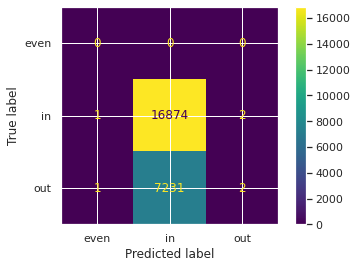

In [42]:
ConfusionMatrixDisplay.from_predictions(INOUT_LAB, INOUT)

# Analysis of the data

In [43]:
N_MODELS = len(x_test_clustered)
print(N_MODELS)

48


In [44]:
BASE_FOLDER = Path("/home/gerardozinno/Desktop/adult_stratified_NEW/gaussian/same")

In [45]:
data = []
for i in range(N_MODELS):
    dd = {}
    path = BASE_FOLDER / f"{i}"
    dd['attack'] = {
        '0' : {
            'data' : np.load(path / "attack" / "0" / "data.npz", allow_pickle=True),
            'model': load_pickle_bz2(path / "attack" / "0" / "model.pkl.bz2")
        },
        '1' : {
            'data' : np.load(path / "attack" / "1" / "data.npz", allow_pickle=True),
            'model': load_pickle_bz2(path / "attack" / "1" / "model.pkl.bz2")
        },
    }
    
    dd['shadow'] = {
        '0' : {
            'data' : np.load(path / "shadow" / "0" / "data.npz", allow_pickle=True),
            'model': load_pickle_bz2(path / "shadow" / "0" / "model.pkl.bz2")
        },
        '1' : {
            'data' : np.load(path / "shadow" / "1" / "data.npz", allow_pickle=True),
            'model': load_pickle_bz2(path / "shadow" / "1" / "model.pkl.bz2")
        },
        '2' : {
            'data' : np.load(path / "shadow" / "2" / "data.npz", allow_pickle=True),
            'model': load_pickle_bz2(path / "shadow" / "2" / "model.pkl.bz2")
        },
        '3' : {
            'data' : np.load(path / "shadow" / "3" / "data.npz", allow_pickle=True),
            'model': load_pickle_bz2(path / "shadow" / "3" / "model.pkl.bz2")
        },
    }
    
    data.append(dd)

# TRAIN

## label 0

In [46]:
for i in range(len(data)):
    print(f"{i}" + 50 * "-")
    x_train_0 = data[i]['attack']['0']['data']['x_train']
    d = pd.DataFrame(x_train_0)
    d['Target'] = x_train_0 = data[i]['attack']['0']['data']['y_train']
    print(d)
    print(d.Target.value_counts(normalize=True))

0--------------------------------------------------
              0         1 Target
0      0.620219  0.379781     in
1      0.517929  0.482071     in
2      0.516015  0.483985     in
3      0.521431  0.478569     in
4      0.521699  0.478301     in
...         ...       ...    ...
13517  0.584508  0.415492     in
13518  0.525199  0.474801     in
13519  0.545112  0.454888     in
13520  0.551204  0.448796     in
13521  0.539180  0.460820     in

[13522 rows x 3 columns]
in     0.977222
out    0.022778
Name: Target, dtype: float64
1--------------------------------------------------
              0         1 Target
0      0.535123  0.464877     in
1      0.545794  0.454206     in
2      0.570032  0.429968     in
3      0.539595  0.460405     in
4      0.528010  0.471990     in
...         ...       ...    ...
13552  0.548420  0.451580     in
13553  0.543570  0.456430     in
13554  0.524983  0.475017     in
13555  0.601156  0.398844     in
13556  0.613326  0.386674     in

[13557 rows x 3 

In [23]:
for i in range(len(data)):
    print(f"{i}" + 50 * "-")
    x_train_0 = data[i]['attack']['1']['data']['x_train']
    d = pd.DataFrame(x_train_0)
    d['Target'] = x_train_0 = data[i]['attack']['1']['data']['y_train']
    print(d)
    print(d.Target.value_counts(normalize=True))

0--------------------------------------------------
              0         1 Target
0      0.444101  0.555899    out
1      0.459822  0.540178     in
2      0.463680  0.536320     in
3      0.417123  0.582877     in
4      0.450925  0.549075     in
...         ...       ...    ...
16519  0.466313  0.533687     in
16520  0.464121  0.535879     in
16521  0.447125  0.552875    out
16522  0.418758  0.581242     in
16523  0.448045  0.551955     in

[16524 rows x 3 columns]
in     0.799685
out    0.200315
Name: Target, dtype: float64
1--------------------------------------------------
              0         1 Target
0      0.446719  0.553281     in
1      0.388165  0.611835    out
2      0.461455  0.538545     in
3      0.457733  0.542267     in
4      0.426218  0.573782    out
...         ...       ...    ...
16576  0.441292  0.558708     in
16577  0.461365  0.538635    out
16578  0.415751  0.584249     in
16579  0.353145  0.646855     in
16580  0.427575  0.572425     in

[16581 rows x 3 

## label 1

In [51]:
for i in range(len(data)):
    print(f"{i}" + 50 * "-")
    x_train_1 = data[i]['attack']['1']['data']['x_train']
    d = pd.DataFrame(x_train_1)
    d['Target'] = x_train_0 = data[i]['attack']['1']['data']['y_train']
    print(d)
    print(d.Target.value_counts(normalize=True))

0--------------------------------------------------
              0         1 Target
0      0.444101  0.555899    out
1      0.459822  0.540178     in
2      0.463680  0.536320     in
3      0.417123  0.582877     in
4      0.450925  0.549075     in
...         ...       ...    ...
16519  0.466313  0.533687     in
16520  0.464121  0.535879     in
16521  0.447125  0.552875    out
16522  0.418758  0.581242     in
16523  0.448045  0.551955     in

[16524 rows x 3 columns]
in     0.799685
out    0.200315
Name: Target, dtype: float64
1--------------------------------------------------
              0         1 Target
0      0.446719  0.553281     in
1      0.388165  0.611835    out
2      0.461455  0.538545     in
3      0.457733  0.542267     in
4      0.426218  0.573782    out
...         ...       ...    ...
16576  0.441292  0.558708     in
16577  0.461365  0.538635    out
16578  0.415751  0.584249     in
16579  0.353145  0.646855     in
16580  0.427575  0.572425     in

[16581 rows x 3 

# TEST

In [47]:
for i in range(len(data)):
    print(f"{i}" + 50 * "-")
    x_train_0 = data[i]['attack']['0']['data']['x_test']
    d = pd.DataFrame(x_train_0)
    d['Target'] = x_train_0 = data[i]['attack']['0']['data']['y_test']
    print(d)
    print(d.Target.value_counts(normalize=True))

0--------------------------------------------------
             0         1 Target
0     0.526358  0.473642     in
1     0.537970  0.462030     in
2     0.533552  0.466448     in
3     0.511584  0.488416     in
4     0.542671  0.457329     in
...        ...       ...    ...
4503  0.525446  0.474554     in
4504  0.501201  0.498799    out
4505  0.517661  0.482339     in
4506  0.532313  0.467687     in
4507  0.594392  0.405608     in

[4508 rows x 3 columns]
in     0.977152
out    0.022848
Name: Target, dtype: float64
1--------------------------------------------------
             0         1 Target
0     0.524849  0.475151     in
1     0.523683  0.476317     in
2     0.529956  0.470044     in
3     0.576448  0.423552     in
4     0.556025  0.443975     in
...        ...       ...    ...
4514  0.561958  0.438042     in
4515  0.533273  0.466727     in
4516  0.538482  0.461518     in
4517  0.538842  0.461158     in
4518  0.516568  0.483432     in

[4519 rows x 3 columns]
in     0.978092
o